In [ ]:
import pandas as pd

df = pd.read_pickle("eeg_sintetico.pkl")

In [ ]:
df

,subject_id,label,FP1,FP2,F7,F8,F3,F4,T3,T4,...,C4,T5,T6,P3,P4,O1,O2,Fz,Cz,Pz
0,0,1,"[0.15587447800554355, 0.048769292252935546, 0....","[-0.6968879461070122, 0.3041051323704602, -0.2...","[0.21046417445643764, -0.5011039978323505, 0.2...","[0.18303634326083004, 0.749975949403681, -0.41...","[0.015935616742674418, -0.4551790928562453, 0....","[-0.3906596334901174, -0.14372275137743712, -0...","[0.2061201754827602, 0.26261352060634746, 0.55...","[0.5150697349605693, 0.020121574552339695, 0.2...",...,"[-0.40108551421875016, 0.888215263654424, 0.06...","[0.14658695189976664, 0.3196109608103265, 0.22...","[-0.18113293859735952, -0.294840608341252, -0....","[0.1386998531603244, 0.4047252273721315, 0.039...","[-0.09162155206774368, -0.5130820276219235, -0...","[0.35194813407593795, -0.024736035982895078, -...","[0.18086983683763597, -0.13258454793621965, 0....","[0.2950850184403256, -0.49017985528384994, 0.4...","[-0.24632716894730672, -0.4725025004401394, -0...","[-0.1756804040692081, -0.02965044501952376, 0...."
1,1,1,"[-0.03979021103450947, -0.15409787416001966, 0...","[-0.024155503243054738, -0.15408441134477466, ...","[-0.3886884401035693, -0.005604558802166581, -...","[-0.24523298784390293, -0.6000420524696534, -0...","[0.11066005471842116, 0.5110741339575443, -0.0...","[0.33077560454690697, -0.24159651232014817, 0....","[0.34660487797241823, -0.039803236740678996, 0...","[0.02580488016898886, 0.18312879701770632, -0....",...,"[0.04148731827688728, -0.4147464802531556, 0.4...","[-0.00736988370343126, -0.28822981134508396, 0...","[-0.19501003683079532, 0.38585018662985887, 0....","[-0.08849100491022789, 0.20587977222299944, -0...","[0.3196469240800905, 0.8507797255650871, -0.43...","[-0.5802213149079919, 0.38811112920811786, -0....","[0.3875610412004299, -0.45831180964543644, -0....","[0.030784914240578564, 0.04455984603183623, -0...","[-0.3852053398712488, 0.05830688683541568, -0....","[-0.11758727562431871, -0.1776706278108205, 0...."
2,2,1,"[-0.7308852577782832, 0.6331634483447823, 0.18...","[0.14340017834713065, -0.41708651789155976, -0...","[0.5997492234290559, -0.26547970400070653, -0....","[0.2524784363902365, -0.27995076798093665, 0.1...","[0.4223506579931446, 0.40185920250899615, -0.0...","[0.7281394235840116, -0.5087121383215768, 0.46...","[-0.7755418652479512, -0.0788045211090522, -0....","[-0.6808254913360005, 0.0024041062399791273, 0...",...,"[0.2247150984377684, -0.07912830588442449, -0....","[0.010792093762172755, 0.6388023807499378, -0....","[-0.7910330202396902, 0.5322224926701894, 0.09...","[0.896112963081652, 0.2259160601161496, -0.850...","[-0.6171890406969667, -0.001500307615138619, -...","[0.7174894105901409, 0.3102244820488897, 0.104...","[0.017696120108697345, 0.609504496434134, 0.36...","[-0.09255084527561272, -0.3383512050992671, 0....","[-0.4079899243538443, -0.40957857315730495, -0...","[0.2693127846006996, 0.8492481791217846, 0.125..."
3,3,1,"[0.13926135016669713, 0.31341738685791276, -0....","[0.7251229185054089, 0.05740628040619821, 0.62...","[0.10858850675719665, -0.15933229941815893, -0...","[0.0168885887953725, 0.09756864990030252, 0.50...","[-0.30985037940465965, 0.18449691148771832, 0....","[0.03875734841802368, -0.005762306493915205, 0...","[0.11295279464044487, 0.19612264223823347, 0.0...","[-0.35660276445858197, 0.24687397929716368, 0....",...,"[0.5614452962438603, -0.3916662485849009, 0.35...","[-0.16242306237856635, -0.3622261056353095, -0...","[-0.37409621666022697, 0.197470025712021, 0.29...","[-0.532842898115002, -0.46019606784703526, -0....","[0.0339680712018202, -0.23731137069794478, -0....","[-0.04048277265618861, 0.4552294299090003, 0.3...","[-0.342336720037937, 0.01792720335064462, 0.01...","[-0.31256621264992845, 0.19301301663607726, 0....","[-0.026360605283680373, 0.2761337835145571, 0....","[0.40361547200099324, -0.020764812083308642, -..."
4,4,2,"[-0.057672758871040994, 0.021908782999175317, ...","[-0.04708345796920925, 0.0028591800521007753, ...","[-0.0021487455704599684, 0.

# Tema 1
Obj: Mostrar competencia de aprendizaje Modelos lineales de regresión

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [ ]:

sensor_cols = ['FP1', 'FP2', 'F7', 'F8', 'F3', 'F4', 'T3', 'T4',
               'C3', 'C4', 'T5', 'T6', 'P3', 'P4', 'O1', 'O2',
               'Fz', 'Cz', 'Pz']

# Asegurar que todas las columnas contengan arrays de NumPy
for col in sensor_cols:
    df[col] = df[col].apply(lambda x: np.array(x) if not isinstance(x, np.ndarray) else x)

# Calcular la media por sujeto (por fila), punto a punto
df['wave_mean'] = df[sensor_cols].apply(lambda row: np.mean(np.vstack(row.values), axis=0), axis=1)


In [ ]:

# Elegir una fila aleatoria del DataFrame
random_row = df.iloc[93]

# Obtener la señal
wave = random_row.wave_mean
# Crear eje de tiempo (de 1 a 2000)
t = np.arange(1, len(wave) + 1)
# Crear DataFrame de la serie de tiempo
ts = pd.Series(wave, index=t)
ts.index = pd.date_range(start="2020-01-01", periods=len(ts), freq="D")
ts

,0
2020-01-01,-0.008081
2020-01-02,-0.022480
2020-01-03,0.043144
2020-01-04,0.077575
2020-01-05,0.046199
...,...
2025-06-18,0.488267
2025-06-19,0.506256
2025-06-20,0.450273
2025-06-21,0.499471


<Axes: >

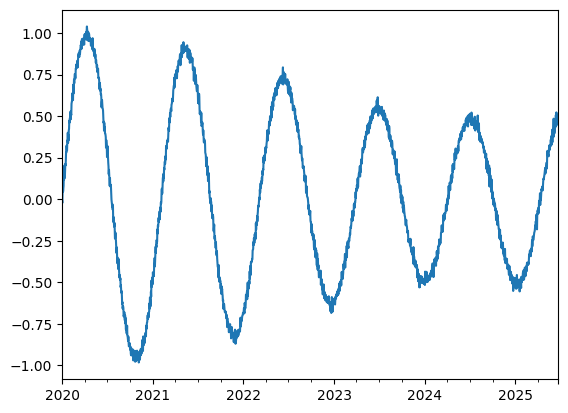

In [ ]:
ts.plot()

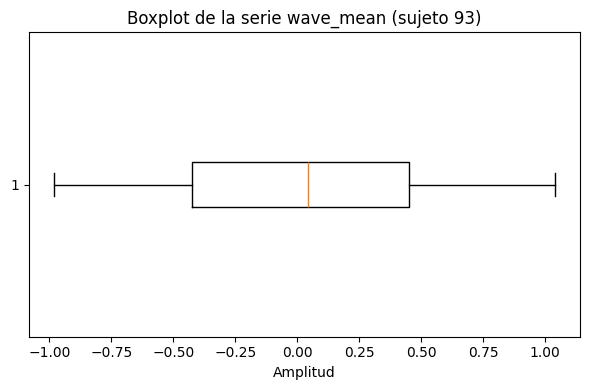

In [ ]:

plt.figure(figsize=(6, 4))
plt.boxplot(ts, vert=False)
plt.title("Boxplot de la serie wave_mean (sujeto 93)")
plt.xlabel("Amplitud")
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Box-Cox (shifted positive)'}>

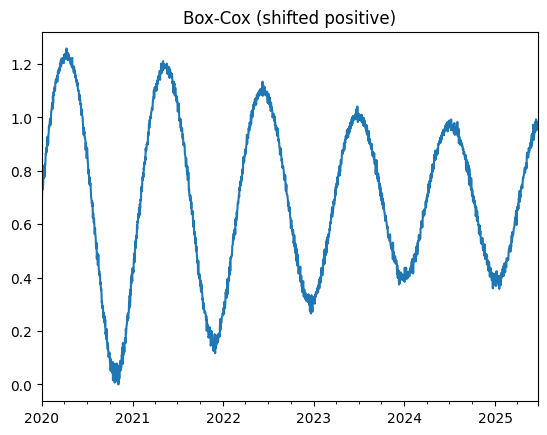

In [ ]:
ts_rescaled = (ts + 1) / 2  # Esto asegura que -1 → 0 y 1 → 1
from scipy import stats

ts_boxcox, lambda_ = stats.boxcox(ts_rescaled)
ts_boxcox = pd.Series(ts_boxcox, index=ts.index)

ts_boxcox_shifted = ts_boxcox - ts_boxcox.min() + 1e-5
ts_boxcox_shifted.plot(title="Box-Cox (shifted positive)")


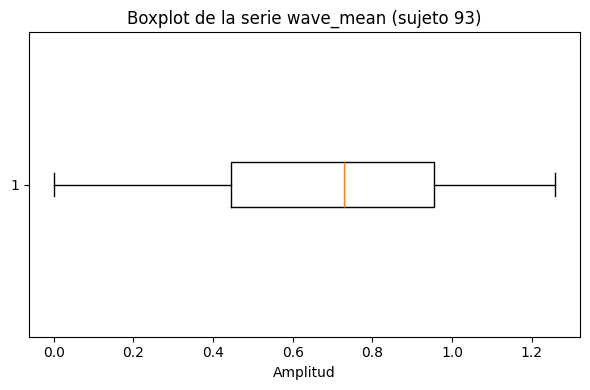

In [ ]:

plt.figure(figsize=(6, 4))
plt.boxplot(ts_boxcox_shifted, vert=False)
plt.title("Boxplot de la serie wave_mean (sujeto 93)")
plt.xlabel("Amplitud")
plt.tight_layout()
plt.show()


In [ ]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
adf_test(ts_boxcox_shifted)

Results of Dickey-Fuller Test:
Test Statistic                -1.298482e+01
p-value                        2.893004e-24
#Lags Used                     2.600000e+01
Number of Observations Used    1.973000e+03
Critical Value (1%)           -3.433669e+00
Critical Value (5%)           -2.863006e+00
Critical Value (10%)          -2.567550e+00
dtype: float64
Stationary


In [ ]:
def mstl_descomposition(data, periods_seasonality, stl_kwargs=None):
    if stl_kwargs is None:
        stl_kwargs = {"seasonal_deg": 0}

    model = MSTL(data, periods=periods_seasonality, stl_kwargs=stl_kwargs)
    res = model.fit()

    fig, ax = plt.subplots(3 + len(periods_seasonality), 1, sharex=True, figsize=(8, 8))

    res.observed.plot(ax=ax[0])
    ax[0].set_ylabel('Observed')

    res.trend.plot(ax=ax[1])
    ax[1].set_ylabel('Trend')

    for i, s_period in enumerate(periods_seasonality):
        res.seasonal[f'seasonal_{s_period}'].plot(ax=ax[i + 2])
        ax[i + 2].set_ylabel(f'seasonal_{s_period}')

    res.resid.plot(ax=ax[2 + len(periods_seasonality)])
    ax[2 + len(periods_seasonality)].set_ylabel('Residual')

    fig.tight_layout()
    return res

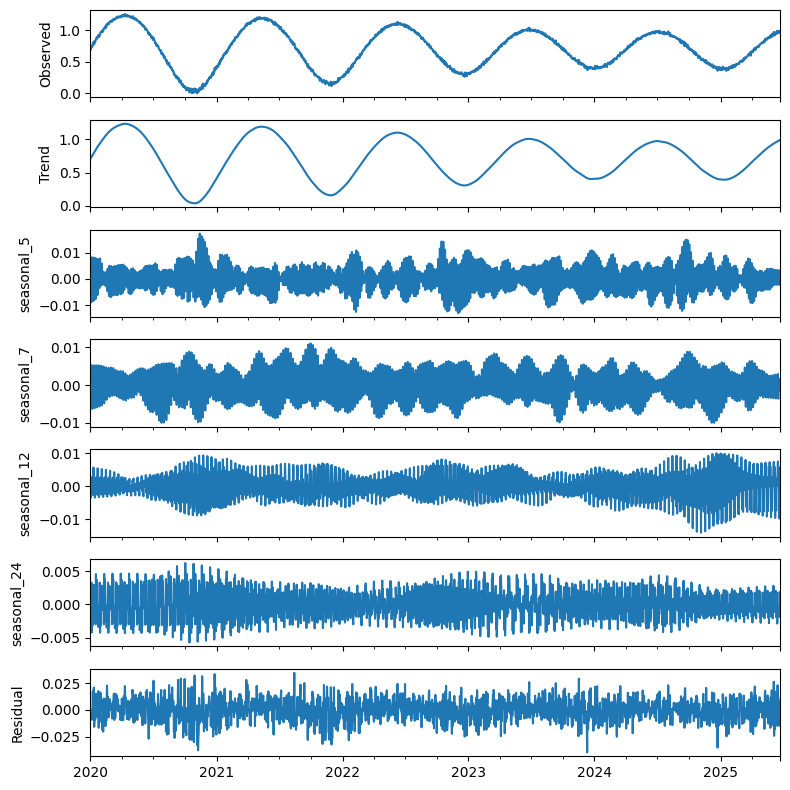

In [ ]:
periods_seasonality = (5 ,7 ,12, 24)

desc = mstl_descomposition(ts_boxcox_shifted, periods_seasonality)

In [ ]:
print()

print('seasonal_5')
adf_test(desc.seasonal['seasonal_5'])
print()

print('seasonal_7')
adf_test(desc.seasonal['seasonal_7'])
print()

print('seasonal_12')
adf_test(desc.seasonal['seasonal_12'])
print()

print('seasonal_24')
adf_test(desc.seasonal['seasonal_24'])
print()

print('residuals')
adf_test(desc.resid)
print()



seasonal_5
Results of Dickey-Fuller Test:
Test Statistic                  -19.202710
p-value                           0.000000
#Lags Used                       25.000000
Number of Observations Used    1974.000000
Critical Value (1%)              -3.433667
Critical Value (5%)              -2.863005
Critical Value (10%)             -2.567550
dtype: float64
Stationary

seasonal_7
Results of Dickey-Fuller Test:
Test Statistic                -1.335810e+01
p-value                        5.496851e-25
#Lags Used                     2.600000e+01
Number of Observations Used    1.973000e+03
Critical Value (1%)           -3.433669e+00
Critical Value (5%)           -2.863006e+00
Critical Value (10%)          -2.567550e+00
dtype: float64
Stationary

seasonal_12
Results of Dickey-Fuller Test:
Test Statistic                -1.621373e+01
p-value                        3.962143e-29
#Lags Used                     2.600000e+01
Number of Observations Used    1.973000e+03
Critical Value (1%)           -3.

In [ ]:
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

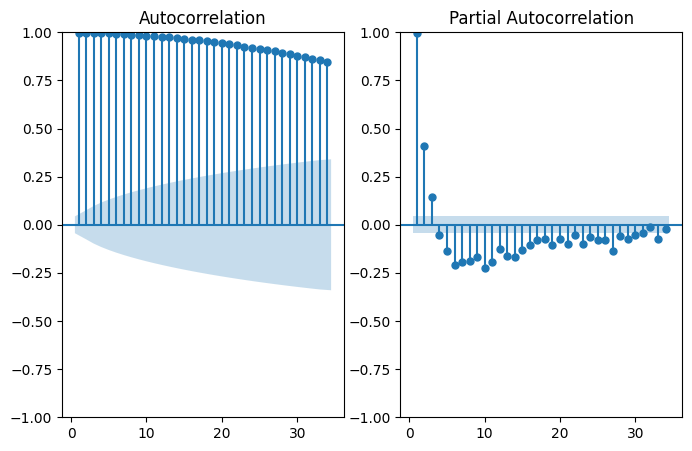

In [ ]:
plot_acf_pacf(ts_boxcox_shifted)

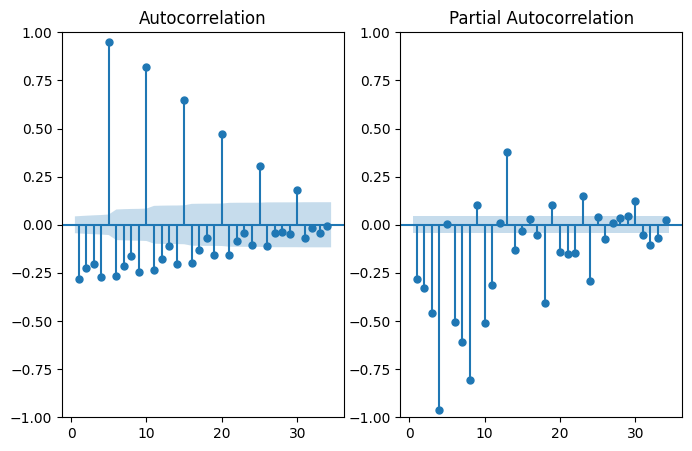

In [ ]:
plot_acf_pacf(desc.seasonal['seasonal_5'])

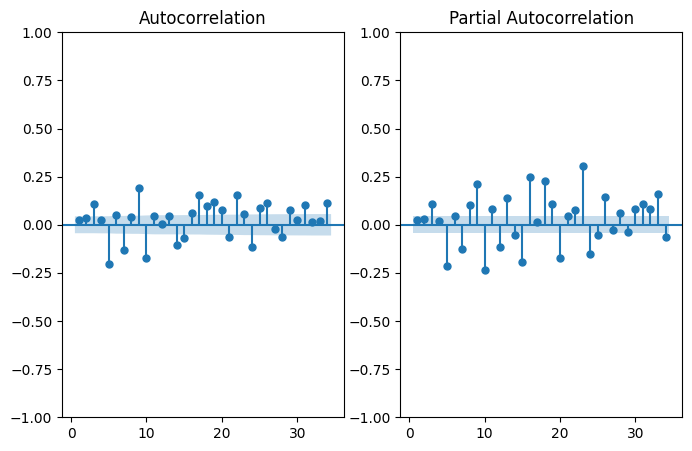

In [ ]:
plot_acf_pacf(desc.resid)

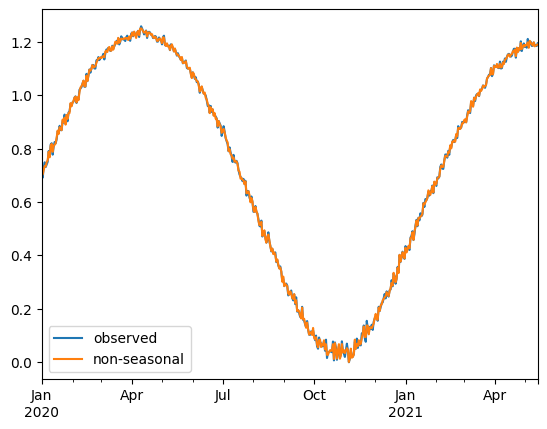

In [ ]:
non_seasonal = desc.observed - desc.seasonal['seasonal_5'] - desc.seasonal['seasonal_7']

desc.observed[:500].plot()
non_seasonal[:500].plot()
plt.legend(['observed', 'non-seasonal'])

In [ ]:
adf_test(non_seasonal)

Results of Dickey-Fuller Test:
Test Statistic                -1.314541e+01
p-value                        1.401610e-24
#Lags Used                     2.600000e+01
Number of Observations Used    1.973000e+03
Critical Value (1%)           -3.433669e+00
Critical Value (5%)           -2.863006e+00
Critical Value (10%)          -2.567550e+00
dtype: float64
Stationary


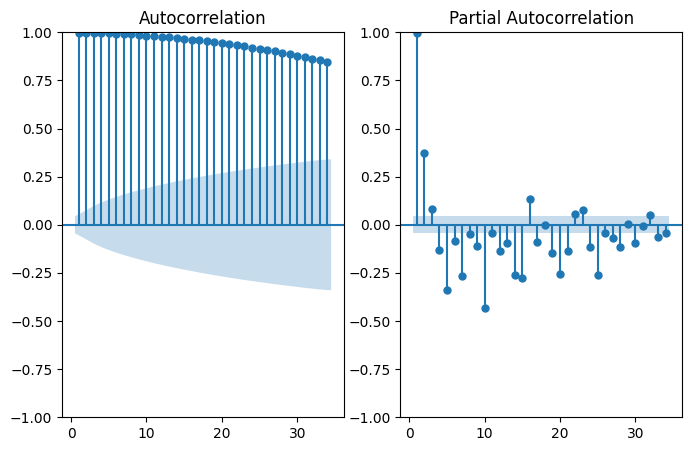

In [ ]:
plot_acf_pacf(non_seasonal)

In [ ]:
n_train = int(0.8 * len(ts_boxcox_shifted))
n_test = len(ts_boxcox_shifted) - n_train

train_data_opt = ts_boxcox_shifted[:n_train]
test_data_opt = ts_boxcox_shifted[-n_test:]

# Crear características de seno y coseno
ts_sin = np.sin(np.linspace(0, len(train_data_opt), len(train_data_opt)))
ts_cos = np.cos(np.linspace(0, len(train_data_opt), len(train_data_opt)))

# Añadir las características al modelo
train_data_opt = pd.DataFrame({
    'sin_component': ts_sin,
    'cos_component': ts_cos,
    'target': train_data_opt
})

# Crear características de seno y coseno para test
ts_sin_test = np.sin(np.linspace(len(train_data_opt), len(train_data_opt) + len(test_data_opt), len(test_data_opt)))
ts_cos_test = np.cos(np.linspace(len(train_data_opt), len(train_data_opt) + len(test_data_opt), len(test_data_opt)))

test_exog = pd.DataFrame({
    'sin_component': ts_sin_test,
    'cos_component': ts_cos_test
}, index=test_data_opt.index)  # importante mantener el índice



In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Suponiendo que `ts` es tu serie temporal
model = SARIMAX(
    train_data_opt['target'],
    exog=train_data_opt[['sin_component', 'cos_component']],
    order=(1, 1, 2),
    seasonal_order=(3, 2, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                              target   No. Observations:                 1600
Model:             SARIMAX(1, 1, 2)x(3, 2, [1], 7)   Log Likelihood                4081.289
Date:                             Mon, 12 May 2025   AIC                          -8142.577
Time:                                     15:38:35   BIC                          -8089.034
Sample:                                 01-01-2020   HQIC                         -8122.671
                                      - 05-18-2024                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
sin_component    -0.0002      0.000     -0.686      0.493      -0.001       0.000
cos_component    -

RMSE (Box-Cox): 0.9506
MAE  (Box-Cox): 0.8272


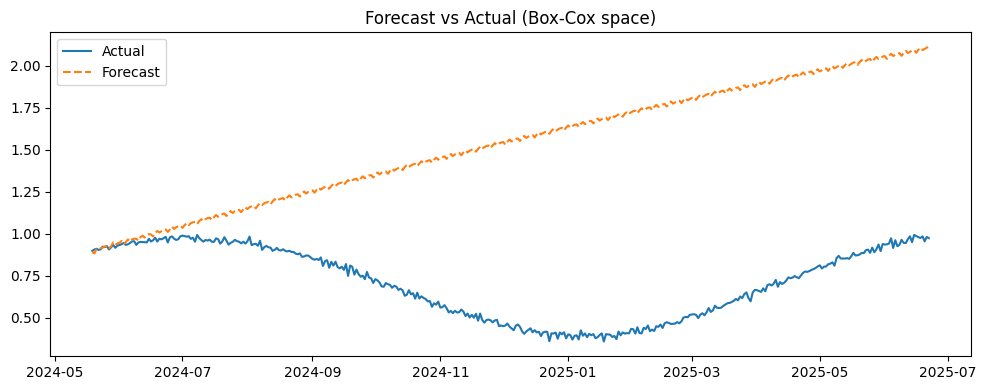

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 2. Predicción
forecast = results.get_forecast(steps=len(test_data_opt), exog=test_exog)
predicted_mean = forecast.predicted_mean

# 3. Evaluación
rmse = np.sqrt(mean_squared_error(test_data_opt, predicted_mean))
mae = mean_absolute_error(test_data_opt, predicted_mean)

print(f'RMSE (Box-Cox): {rmse:.4f}')
print(f'MAE  (Box-Cox): {mae:.4f}')

# Graficar
plt.figure(figsize=(10, 4))
plt.plot(test_data_opt.index, test_data_opt, label='Actual')
plt.plot(test_data_opt.index, predicted_mean, label='Forecast', linestyle='--')
plt.title('Forecast vs Actual (Box-Cox space)')
plt.legend()
plt.tight_layout()
plt.show()



Modelo SARIMA(1, 1, 1) x (3, 2, 1)7
RMSE: 0.9584 | MAE: 0.8348


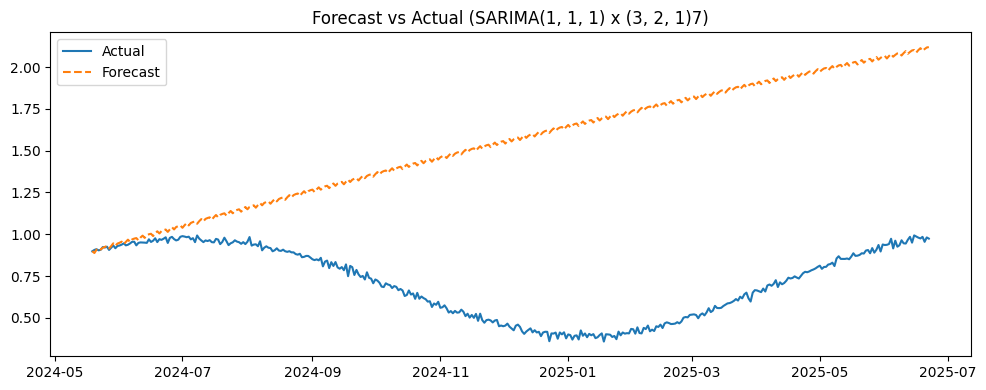

NUEVO MEJOR MODELO: SARIMA(1, 1, 1) x (3, 2, 1)7 con RMSE=0.9584
Modelo SARIMA(1, 1, 2) x (3, 2, 1)7
RMSE: 0.2914 | MAE: 0.2388


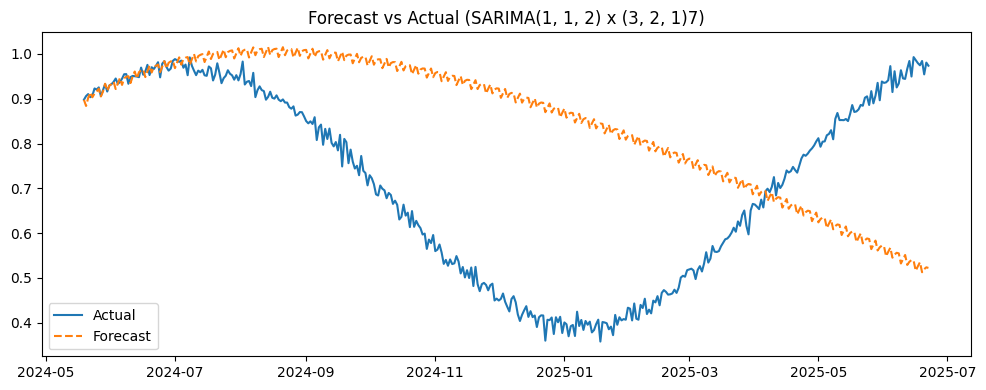

NUEVO MEJOR MODELO: SARIMA(1, 1, 2) x (3, 2, 1)7 con RMSE=0.2914
Modelo SARIMA(1, 1, 3) x (3, 2, 1)7
RMSE: 0.9415 | MAE: 0.8201


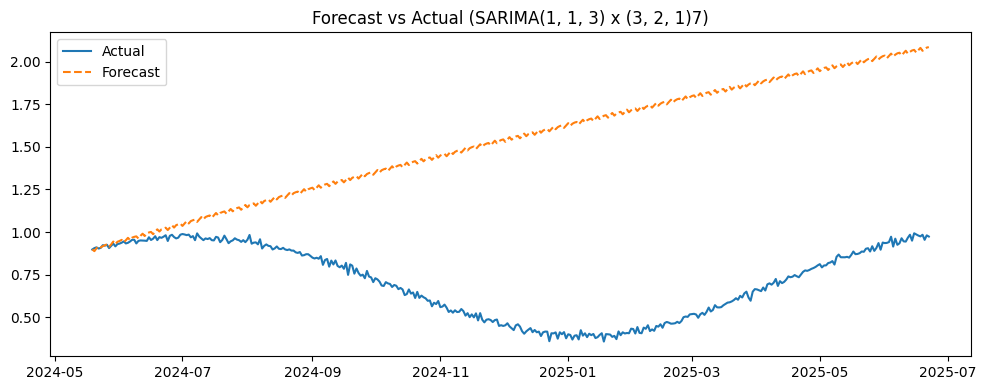

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Modelo SARIMA(1, 2, 1) x (3, 2, 1)7
RMSE: 2.0533 | MAE: 1.7037


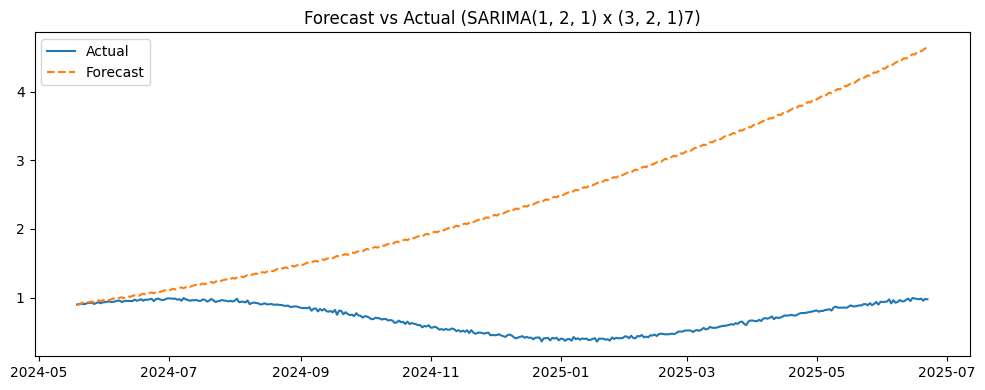

Modelo SARIMA(1, 2, 2) x (3, 2, 1)7
RMSE: 0.3839 | MAE: 0.3196


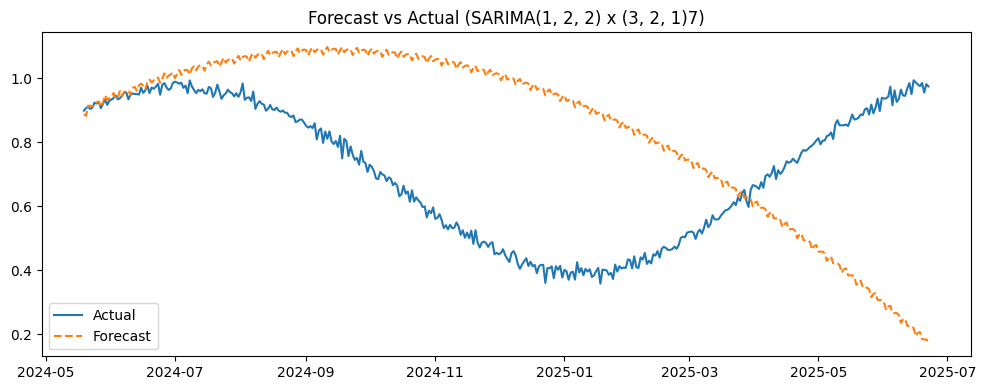

Modelo SARIMA(1, 2, 3) x (3, 2, 1)7
RMSE: 2.2916 | MAE: 1.5086


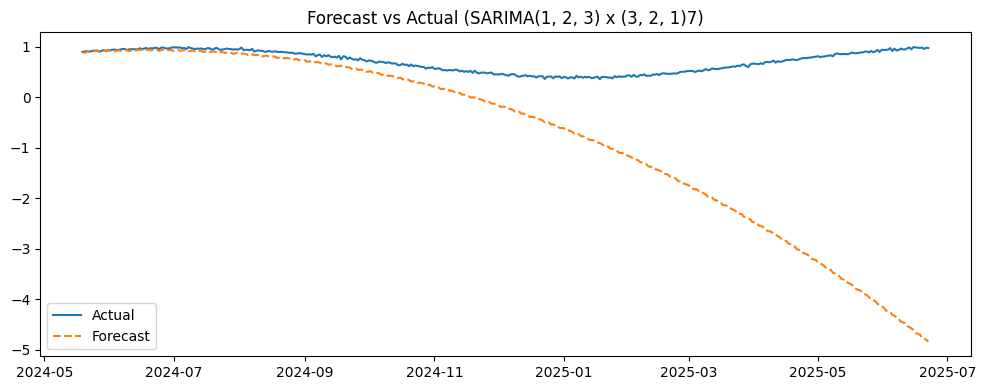

Modelo SARIMA(1, 3, 1) x (3, 2, 1)7
RMSE: 21.2960 | MAE: 16.0998


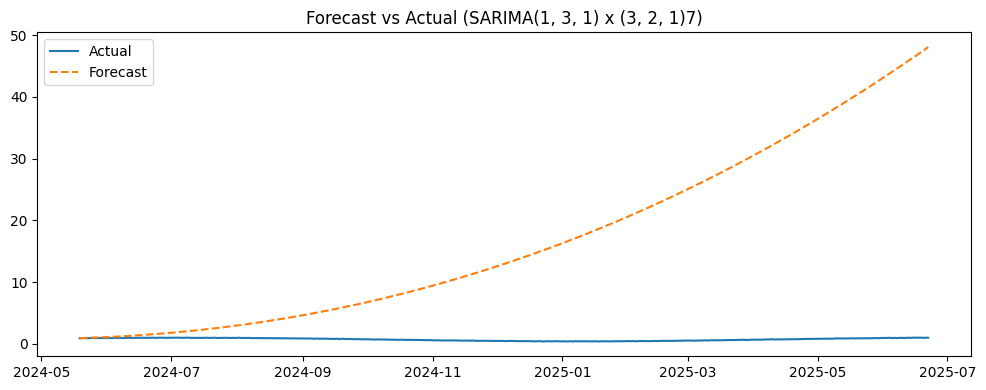

Modelo SARIMA(1, 3, 2) x (3, 2, 1)7
RMSE: 1.1507 | MAE: 0.7190


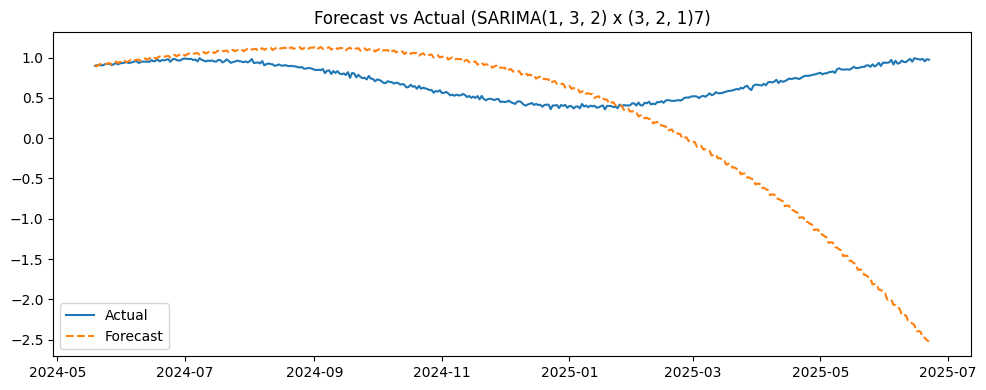

Modelo SARIMA(1, 3, 3) x (3, 2, 1)7
RMSE: 2.0226 | MAE: 1.1816


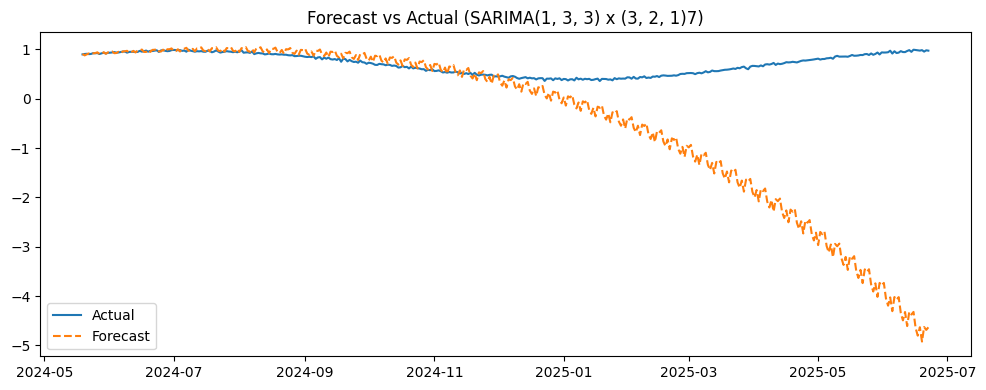

Modelo SARIMA(2, 1, 1) x (3, 2, 1)7
RMSE: 1.1344 | MAE: 0.9807


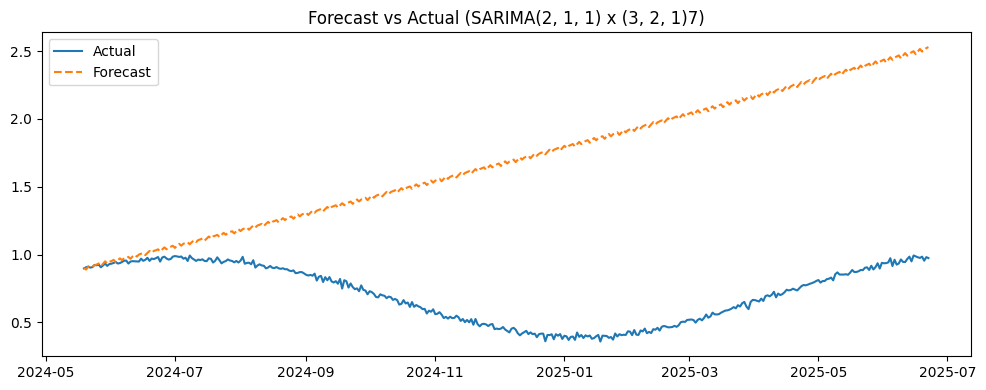

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Modelo SARIMA(2, 1, 2) x (3, 2, 1)7
RMSE: 0.3928 | MAE: 0.3239


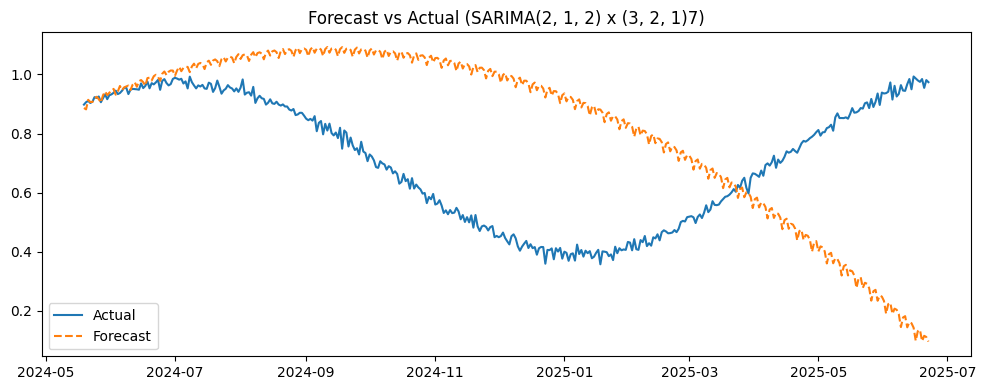

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Modelo SARIMA(2, 1, 3) x (3, 2, 1)7
RMSE: 0.9643 | MAE: 0.8400


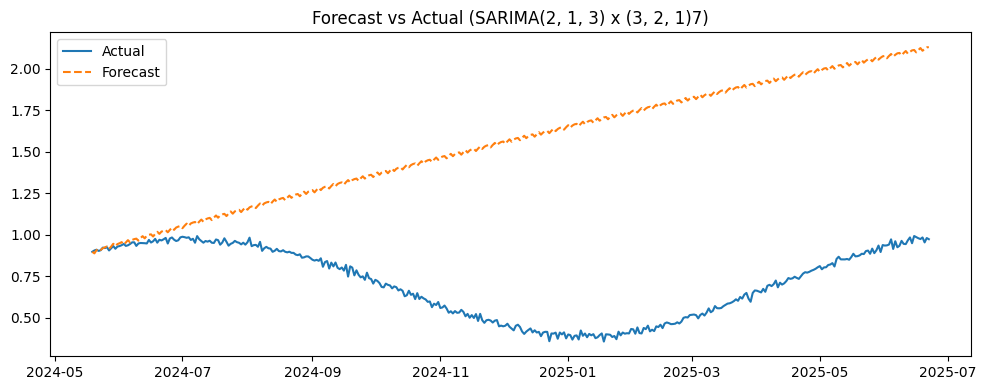

Modelo SARIMA(2, 2, 1) x (3, 2, 1)7
RMSE: 2.0596 | MAE: 1.6952


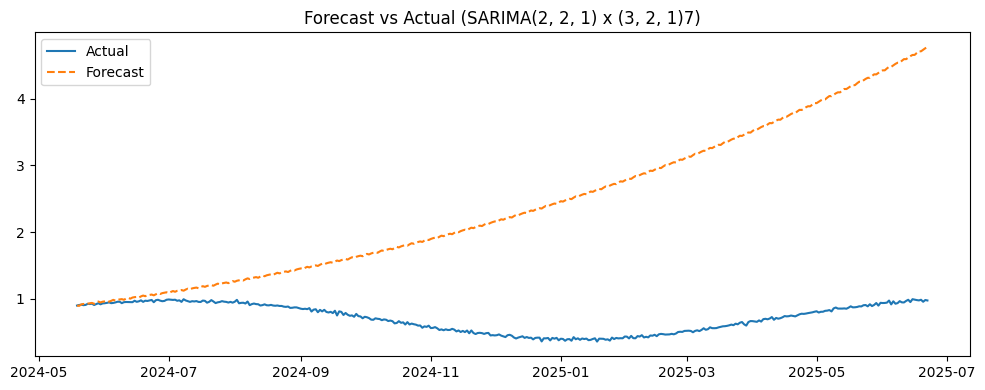

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Modelo SARIMA(2, 2, 2) x (3, 2, 1)7
RMSE: 0.5797 | MAE: 0.3986


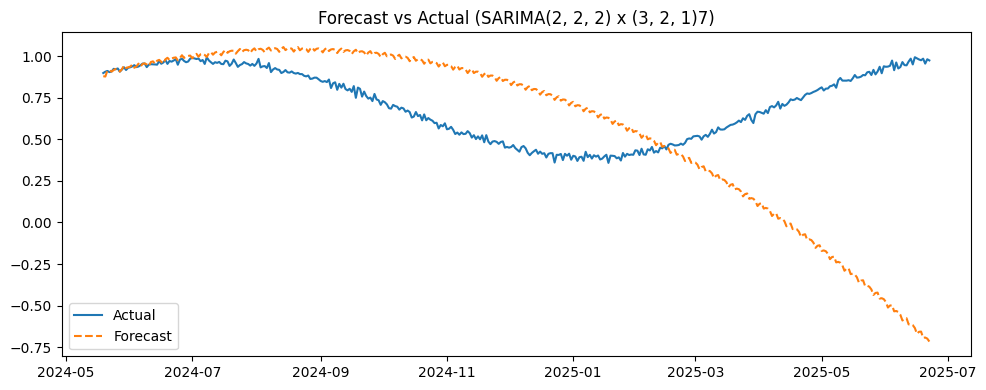

Modelo SARIMA(2, 2, 3) x (3, 2, 1)7
RMSE: 0.8142 | MAE: 0.4935


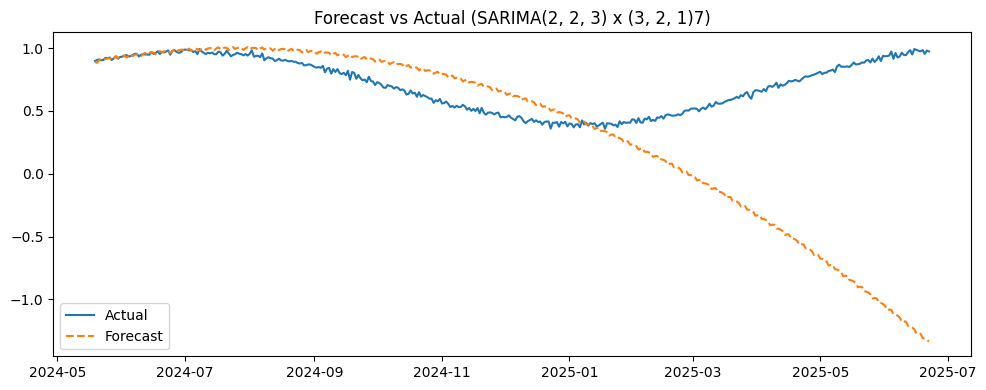

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Modelo SARIMA(2, 3, 1) x (3, 2, 1)7
RMSE: 16.0901 | MAE: 12.1749


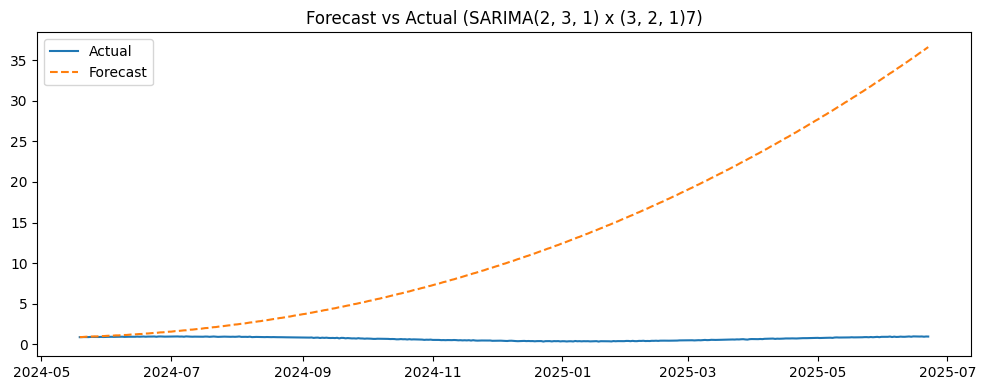

Modelo SARIMA(2, 3, 2) x (3, 2, 1)7
RMSE: 84.0403 | MAE: 57.0996


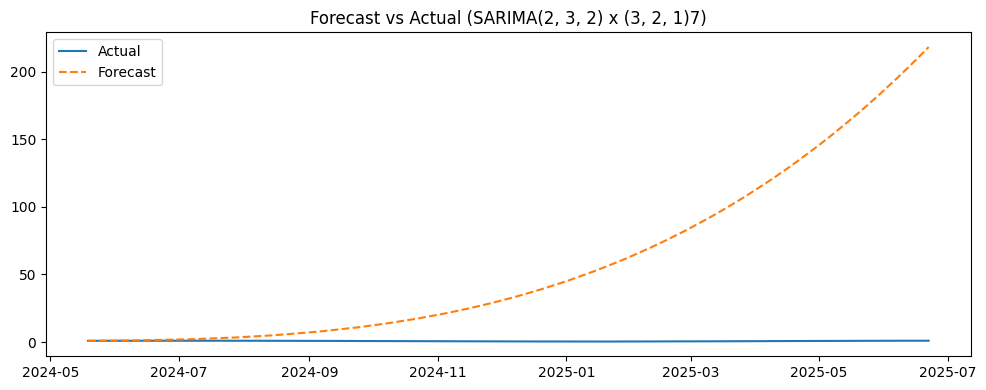

Modelo SARIMA(2, 3, 3) x (3, 2, 1)7
RMSE: 7.1071 | MAE: 4.5035


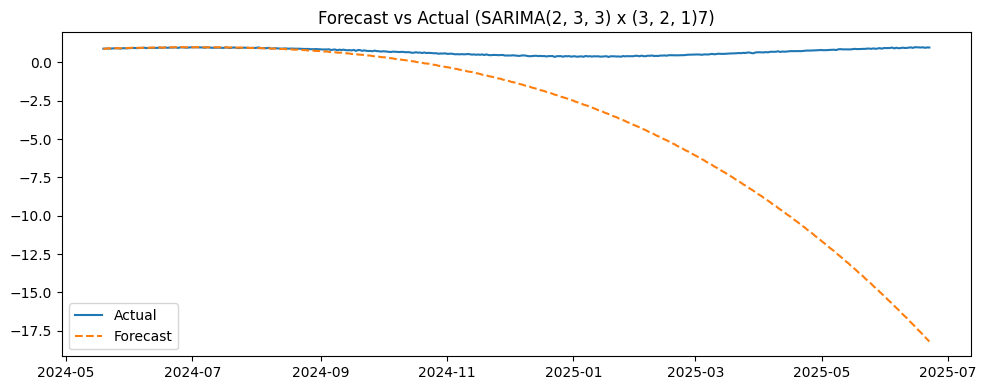

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Modelo SARIMA(3, 1, 1) x (3, 2, 1)7
RMSE: 0.9619 | MAE: 0.8380


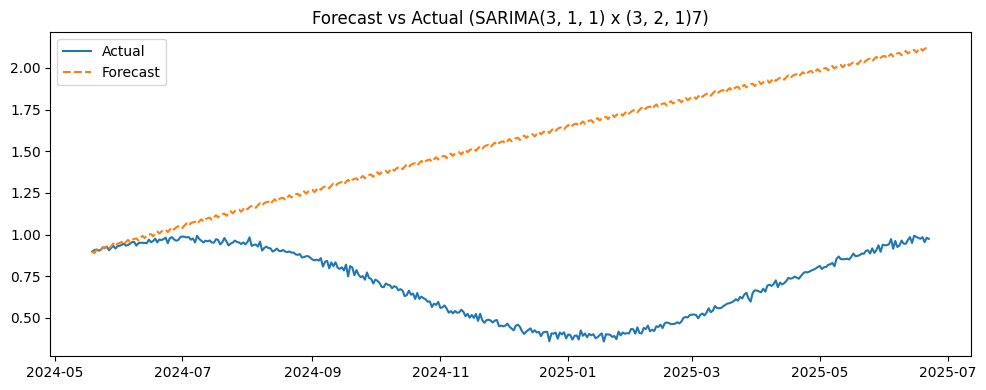

Modelo SARIMA(3, 1, 2) x (3, 2, 1)7
RMSE: 0.4532 | MAE: 0.3780


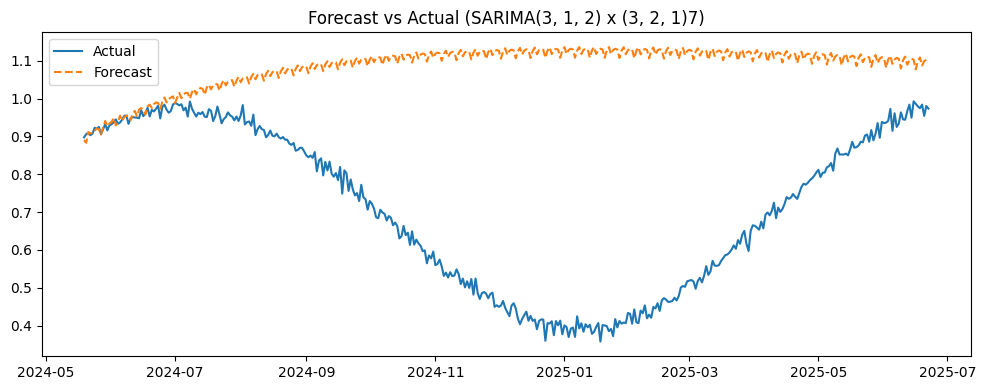

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Modelo SARIMA(3, 1, 3) x (3, 2, 1)7
RMSE: 1.5918 | MAE: 1.3437


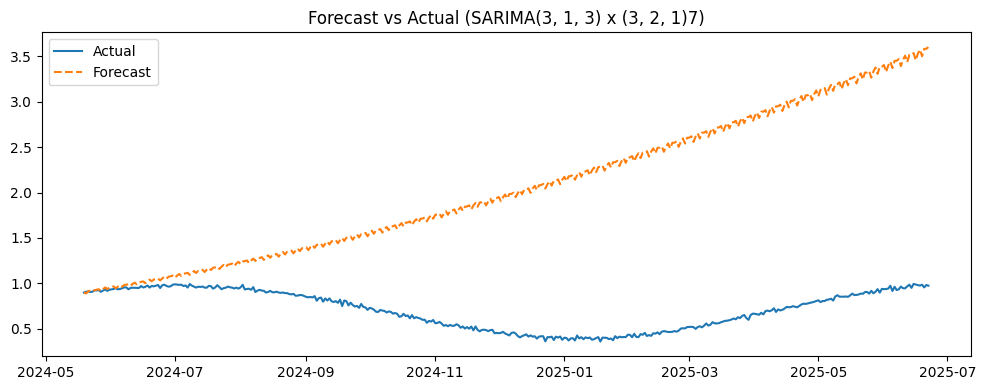

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Modelo SARIMA(3, 2, 1) x (3, 2, 1)7
RMSE: 1.3641 | MAE: 1.1551


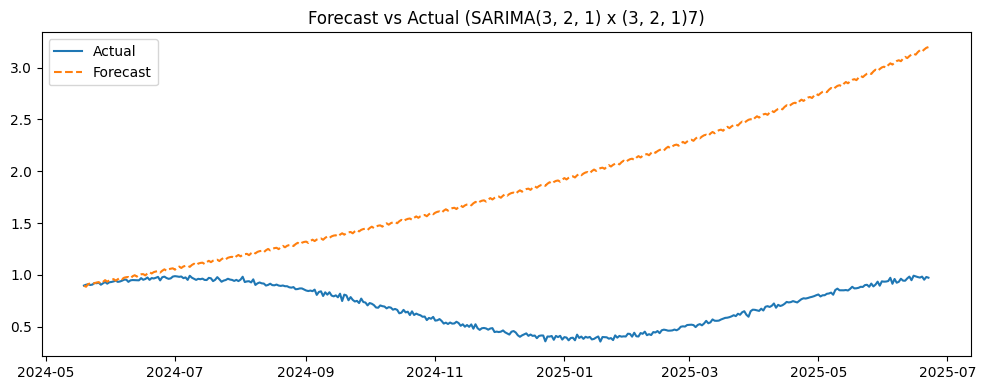

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Modelo SARIMA(3, 2, 2) x (3, 2, 1)7
RMSE: 5.9932 | MAE: 3.9173


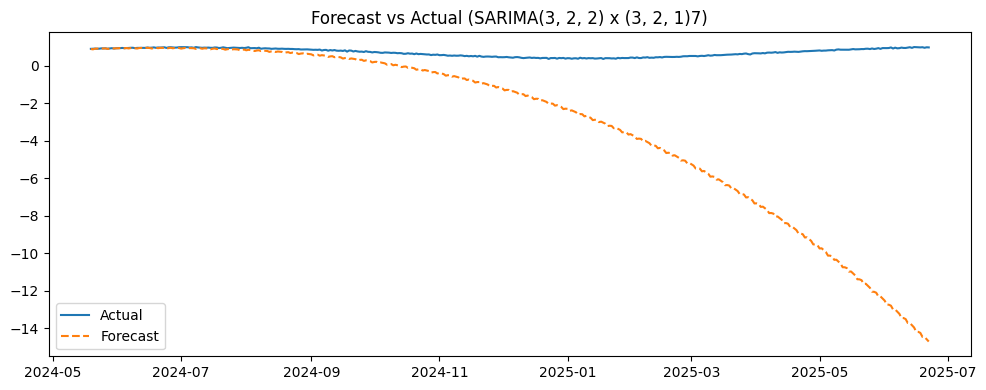

Modelo SARIMA(3, 2, 3) x (3, 2, 1)7
RMSE: 1.5010 | MAE: 1.2613


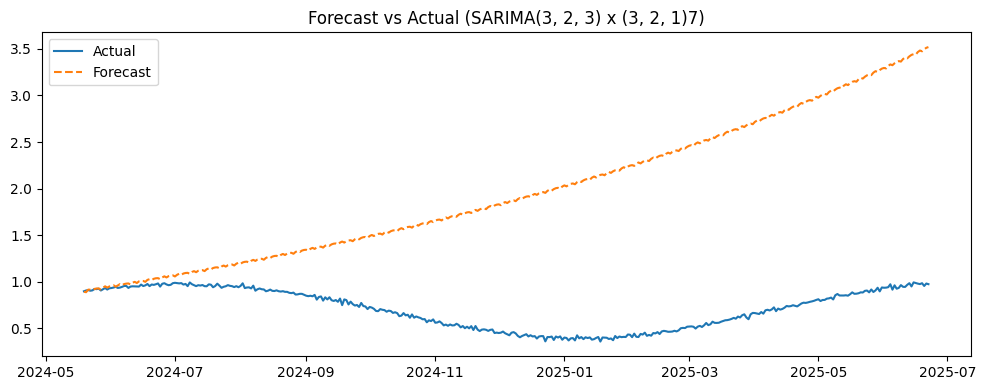

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Modelo SARIMA(3, 3, 1) x (3, 2, 1)7
RMSE: 13.9081 | MAE: 10.4291


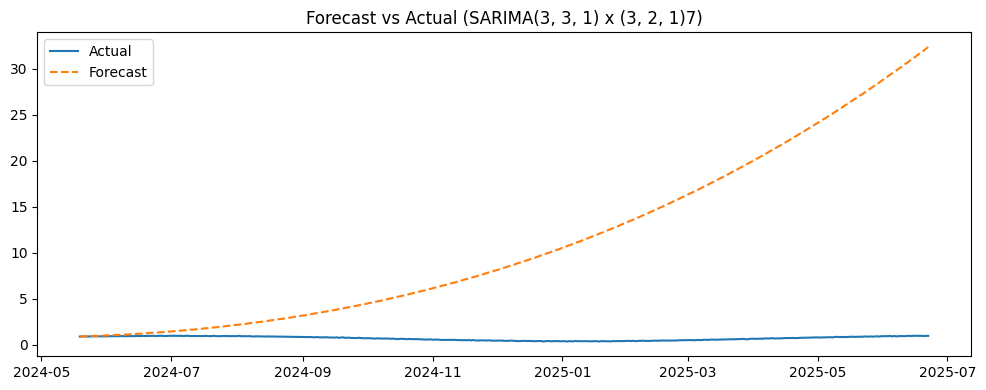

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Modelo SARIMA(3, 3, 2) x (3, 2, 1)7
RMSE: 89.3125 | MAE: 61.1999


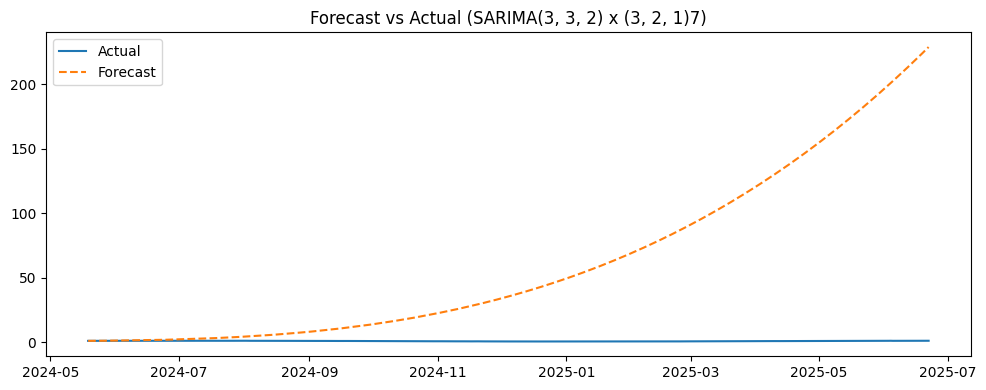

Modelo SARIMA(3, 3, 3) x (3, 2, 1)7
RMSE: 2.9338 | MAE: 1.6918


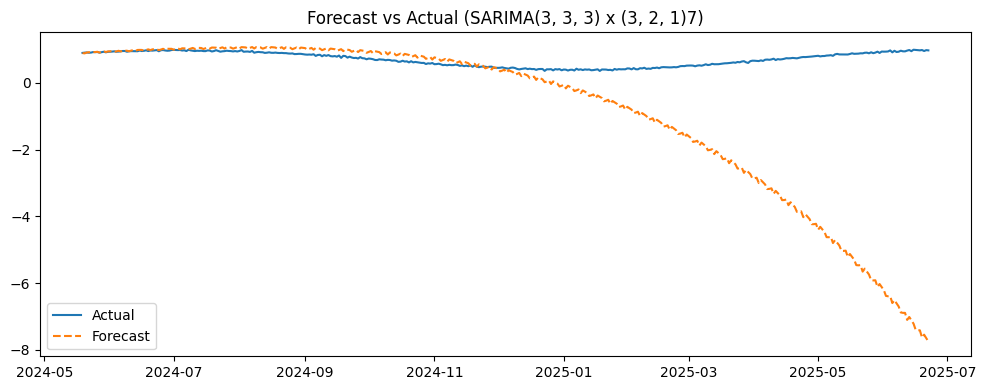


--- Mejor modelo encontrado ---
Orden: (1, 1, 2)
Orden estacional: (3, 2, 1)7
RMSE: 0.2914


In [ ]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define los rangos máximos (basado en tus valores)
p = [1,2,3]
d = [1,2,3]
q = [1,2,3]

P = [3]
D = [2]
Q = [1]

s = 7  # Periodo estacional

# Generar todas las combinaciones posibles
orders = list(itertools.product(p, d, q))
seasonal_orders = list(itertools.product(P, D, Q))

# Inicializar variables para almacenar el mejor modelo
best_rmse = np.inf
best_order = None
best_seasonal_order = None
best_model = None

# Loop de búsqueda
for order in orders:
    for seasonal in seasonal_orders:
        try:
            model = SARIMAX(train_data_opt,
                            order=order,
                            seasonal_order=(seasonal[0], seasonal[1], seasonal[2], s),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)

            # 2. Predicción
            forecast = results.get_forecast(steps=len(test_data_opt))
            predicted_mean = forecast.predicted_mean

            # 3. Evaluación
            rmse = np.sqrt(mean_squared_error(test_data_opt, predicted_mean))
            mae = mean_absolute_error(test_data_opt, predicted_mean)

            # Mostrar las métricas de rendimiento
            print(f"Modelo SARIMA{order} x {seasonal}7")
            print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f}")

            # Graficar la predicción vs la realidad (en escala Box-Cox)
            plt.figure(figsize=(10, 4))
            plt.plot(test_data_opt.index, test_data_opt, label='Actual')
            plt.plot(test_data_opt.index, predicted_mean, label='Forecast', linestyle='--')
            plt.title(f'Forecast vs Actual (SARIMA{order} x {seasonal}7)')
            plt.legend()
            plt.tight_layout()
            plt.show()

            # Si el modelo actual tiene un RMSE menor, lo actualizamos como el mejor
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal
                best_model = results
                print(f"NUEVO MEJOR MODELO: SARIMA{order} x {seasonal}7 con RMSE={rmse:.4f}")

        except Exception as e:
            print(f"Error con orden={order} y seasonal={seasonal}: {e}")
            continue

print("\n--- Mejor modelo encontrado ---")
print(f"Orden: {best_order}")
print(f"Orden estacional: {best_seasonal_order}7")
print(f"RMSE: {best_rmse:.4f}")


# Tema 2

# Tema 3